In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, os
import ndreg
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import skimage

## MetaData

In [8]:
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
COLLECTION = 'ailey-dev'
EXPERIMENT = "Thy1eYFP_Control_9_upload20170919"
CHANNEL = "Ch1"
RES = 3
x_range = [0, 2160]
y_range = [0, 2560]
z_range = [0, 1425]
resolution = 3
SAVE_DIR = '../Data/Thy1eYFP/'
INTERN_CFG_DIR = './intern.cfg'

In [9]:
def get_img(col, exp, ch, res=3, intern_cfg = './intern.cfg'):
    rmt = BossRemote(cfg_file_or_dict=intern_cfg)
    return rmt, ndreg.download_image(rmt, col, exp, ch, res=res)

# Download brain volume and atlas

In [10]:
rmt, img = get_img(COLLECTION, EXPERIMENT, CHANNEL)
atlas = ndreg.download_ara(rmt, 50)

In [11]:
print(img.GetSize())
print(atlas.GetSize())

(270, 320, 178)
(264, 160, 228)


# Preprocessing

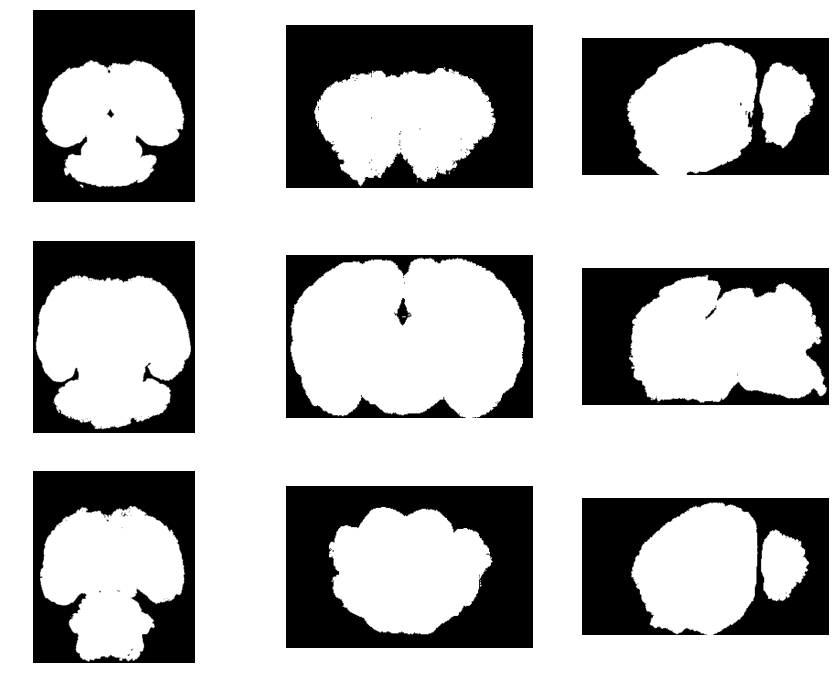

In [12]:
mask_sitk = preprocessor.create_mask(img, use_triangle=True)
ndreg.imgShow(mask_sitk, vmax=1)

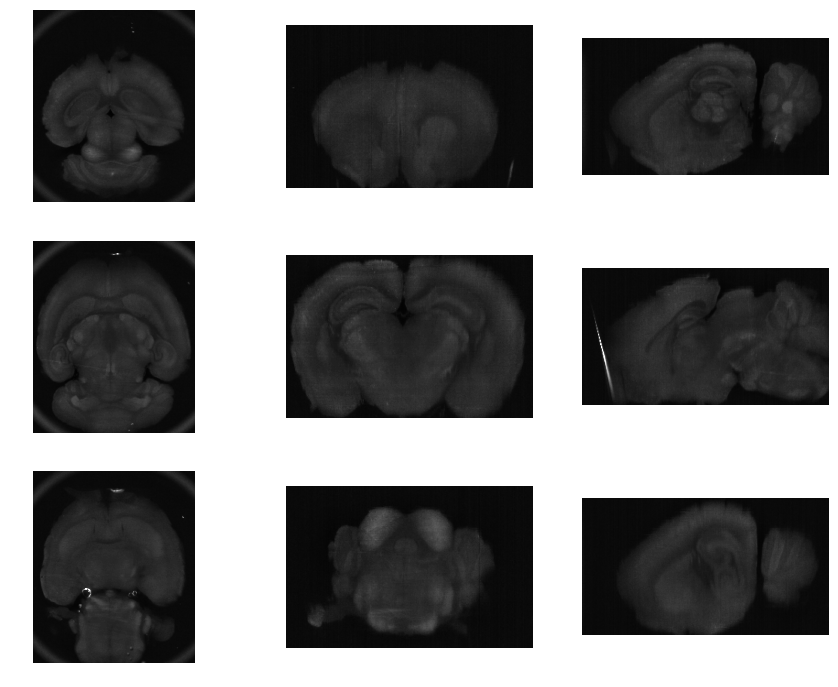

In [13]:
img_bc = preprocessor.correct_bias_field(img, scale=1.0,
                                         spline_order=4, num_control_pts=[5,5,5],
                                         niters=[200, 200, 200, 50])
ndreg.imgShow(img_bc, vmax=2500)

In [14]:
img_bc_ds = sitk.Normalize(atlas)
atlas_ds = sitk.Normalize(img_bc)
atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(img_bc_ds, atlas_ds, "pir", "lps", 0.05, default_value=ndreg.imgPercentile(img_bc_ds, 0.01))
ndreg.imgShow(atlas_ds)

TypeError: downsample_and_reorient() got an unexpected keyword argument 'default_value'

In [ ]:
ndreg.imgShow(img_bc_ds, vmax=3, vmin=-3)

# Affine registration

In [ ]:
final_transform = registerer.register_affine(atlas_ds,
                                            img_bc_ds,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.6, 0.3, 0.150],
                                            verbose=True)

In [ ]:
out_atlas = registerer.resample(atlas_ds, final_transform, atlas_ds)
out_target = registerer.resample(img_bc_ds, final_transform.GetInverse(), img_bc_ds)

In [ ]:
img = sitk.GetArrayFromImage(out_atlas)

In [ ]:
ndreg.imgShow(out_atlas)
ndreg.imgShow(out_target, vmax=3, vmin=-3)

In [ ]:
ndreg.imgShow(ndreg.imgChecker(out_target, sitk.Normalize(atlas)), vmax=3, vmin=-3)

# LDDMM registration

In [ ]:
WHITEN_RADIUS = [5,5,5]
ALPHA = 0.25
BETA = 0.25

In [ ]:
out_target_whitened = preprocessor.whiten(out_target, radius=WHITEN_RADIUS, alpha=ALPHA, beta=BETA)

In [ ]:
atlas_ds_whitened = preprocessor.whiten(atlas_ds, radius=WHITEN_RADIUS)

In [ ]:
out_atlas_whitened = preprocessor.whiten(out_atlas, radius=WHITEN_RADIUS)
img_bc_ds_whitened = preprocessor.whiten(img_bc_ds, radius=WHITEN_RADIUS)

In [ ]:
ndreg.imgShow(out_target_whitened)

In [ ]:
ndreg.imgShow(out_atlas_whitened, vmax=3)

In [ ]:
ndreg.imgShow(sitk.Normalize(img_bc_ds_whitened), vmin=-3, vmax=3)

In [ ]:
ndreg.imgShow(atlas_ds_whitened)

In [ ]:
atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas_whitened), 
                                                          target_img=sitk.Normalize(img_bc_ds_whitened),
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=7e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)

In [ ]:
ndreg.imgShow(atlas_lddmm)

In [ ]:
ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(img_bc_ds_whitened), sitk.Normalize(atlas_lddmm)), vmax=1, vmin=-1)

In [ ]:
atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas_whitened), 
                                                          target_img=sitk.Normalize(out_target_whitened),
                         i                                 alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=7e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)